In [1]:
# Import libraries for data wrangling 
import pandas as pd
import numpy as np 

# Read in csv data 
referrals_info = pd.read_csv(r'C:\Users\johna\OneDrive\Documents\Bulb\Bulb_-_Data_coding_excercise (3)\Bulb - Data Scientist coding excercise\180601_Referrals_Info.csv')
customer_info = pd.read_csv(r'C:\Users\johna\OneDrive\Documents\Bulb\Bulb_-_Data_coding_excercise (3)\Bulb - Data Scientist coding excercise\180601_Customer_Info.csv')

referrals_info.rename(columns = {'referrer_customer_id':'customer_id'}, inplace=True)

# drop duplicates observations in both data sets
print(len(referrals_info),len(customer_info))
referrals_info = referrals_info.drop_duplicates()
customer_info = customer_info.drop_duplicates()
print(len(referrals_info),len(customer_info))

print('missing referrals info', referrals_info.isna().sum())
print('missing customer info', customer_info.isna().sum())

1000 1699
1000 1699
missing referrals info referral_date          0
customer_id            0
sign_up_customer_id    0
dtype: int64
missing customer info customer_id        0
sign_up_date       0
sign_up_channel    0
dtype: int64


# Data Wrangling and Feature Engineering

In [2]:
# Left join referalls_info on to cutomer_info on customer_id  table to create a customer_life table
customer_life = pd.merge(customer_info, referrals_info, on='customer_id', how='left')

# Create a referrer flag which will (yes/no) to identify referrers and non-refererrs
customer_life['referrer'] = np.where(customer_life.referral_date.isnull() == True, 0, 1)

# Create feature time_to_referral as difference between referral_date and sign_up_date 
customer_life['sign_up_date'] = pd.to_datetime(customer_life.sign_up_date)
customer_life['referral_date'] = pd.to_datetime(customer_life.referral_date)
customer_life['time_to_referral'] = (customer_life.referral_date - customer_life.sign_up_date).dt.days

# Cerate feature to determine length of time customer has been with Bulb (assuming all customers are currently still bulb customers)
# Note that many dates are in the future so today's date assumed to be latest referal date
today = customer_life['sign_up_date'].max()
customer_life['time_with_Bulb'] = (today - customer_life.sign_up_date).dt.days

# One customer can referral multiple people identify how many referrals per customer
customer_life.sort_values(by=['customer_id', 'referral_date'], axis=0, inplace=True)
customer_life['No_of_Referrals'] = customer_life.customer_id.map(customer_life.customer_id.value_counts())

# Idnteify first column entry
customer_life.loc[customer_life.groupby('customer_id',as_index=False).head(1).index,'First'] = 'Yes'

# Isolate the referrers from the customer life table
referrer_cust_life = customer_life.loc[customer_life.referrer == 1]

# Isolate Non-referrers 
Non_referrers = customer_life.loc[customer_life['referrer'] == 0]

# Isolate first entry for customer life
customer_life_first = customer_life.loc[customer_life.First == 'Yes']

# Isolate first referral instances from all referrers
ref_customer_life_first = referrer_cust_life.loc[referrer_cust_life.First == 'Yes']


# Descriptive Statistics

In [3]:
# Calculate an average time to referral with a confidence interval
import scipy.stats

# Function to calculate confidence interval around mean
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return print('Mean',m), print('Lower Bound',m-h) , print('Upper Bound', m+h)


In [4]:
# Generate descriptive stats for all customers 
print('All customer life')
print('Confidence interval for average Membership (days) 95%')
print(mean_confidence_interval(customer_life.time_with_Bulb))
customer_life.describe()


All customer life
Confidence interval for average Membership (days) 95%
Mean 221.1558228540186
Lower Bound 214.4010148285196
Upper Bound 227.91063087951758
(None, None, None)


,customer_id,sign_up_customer_id,referrer,time_to_referral,time_with_Bulb,No_of_Referrals
count,1829.000000,832.000000,1829.000000,832.000000,1829.000000,1829.000000
mean,1456.198469,1353.899038,0.454893,113.653846,221.155823,1.926189
std,1021.746350,296.568764,0.498097,112.996269,147.293684,4.622810
min,0.000000,260.000000,0.000000,0.000000,0.000000,1.000000
25%,407.000000,1106.750000,0.000000,24.000000,125.000000,1.000000
50%,1939.000000,1352.500000,0.000000,83.500000,189.000000,1.000000
75%,2396.000000,1613.250000,1.000000,167.250000,296.000000,1.000000
max,2853.000000,1859.000000,1.000000,700.000000,972.000000,34.000000


In [5]:
# Generate descriptive stats for customer whom referred a friend
print('Customer who referred a friend')
print('Confidence interval for average Membership (days) 95%')
print(mean_confidence_interval(referrer_cust_life.time_with_Bulb))
print('Confidence interval for time to first referral (days) 95%')
print(mean_confidence_interval(ref_customer_life_first.time_to_referral))
referrer_cust_life.describe()


Customer who referred a friend
Confidence interval for average Membership (days) 95%
Mean 272.3161057692308
Lower Bound 263.0670094227657
Upper Bound 281.56520211569585
(None, None, None)
Confidence interval for time to first referral (days) 95%
Mean 102.95292439372325
Lower Bound 94.50227500864287
Upper Bound 111.40357377880363
(None, None, None)


,customer_id,sign_up_customer_id,referrer,time_to_referral,time_with_Bulb,No_of_Referrals
count,832.000000,832.000000,832.0,832.000000,832.000000,832.000000
mean,380.856971,1353.899038,1.0,113.653846,272.316106,3.036058
std,265.374462,296.568764,0.0,112.996269,135.918907,6.689334
min,0.000000,260.000000,1.0,0.000000,5.000000,1.000000
25%,140.000000,1106.750000,1.0,24.000000,169.000000,1.000000
50%,355.500000,1352.500000,1.0,83.500000,256.500000,1.000000
75%,612.250000,1613.250000,1.0,167.250000,358.000000,1.000000
max,868.000000,1859.000000,1.0,700.000000,972.000000,34.000000


In [6]:
# Generate descriptive statistics for customer who didn't refer a freind
print('Customers who did not referred a friend')
print('Confidence interval for average Membership (days) 95%')
print(mean_confidence_interval(Non_referrers.time_with_Bulb))
Non_referrers.describe()


Customers who did not referred a friend
Confidence interval for average Membership (days) 95%
Mean 178.46238716148446
Lower Bound 169.58714218988348
Upper Bound 187.33763213308544
(None, None, None)


,customer_id,sign_up_customer_id,referrer,time_to_referral,time_with_Bulb,No_of_Referrals
count,997.000000,0.0,997.0,0.0,997.000000,997.0
mean,2353.574724,NaN,0.0,NaN,178.462387,1.0
std,291.939659,NaN,0.0,NaN,142.807745,0.0
min,1021.000000,NaN,0.0,NaN,0.000000,1.0
25%,2106.000000,NaN,0.0,NaN,57.000000,1.0
50%,2355.000000,NaN,0.0,NaN,163.000000,1.0
75%,2604.000000,NaN,0.0,NaN,262.000000,1.0
max,2853.000000,NaN,0.0,NaN,817.000000,1.0


# Data Visulisation

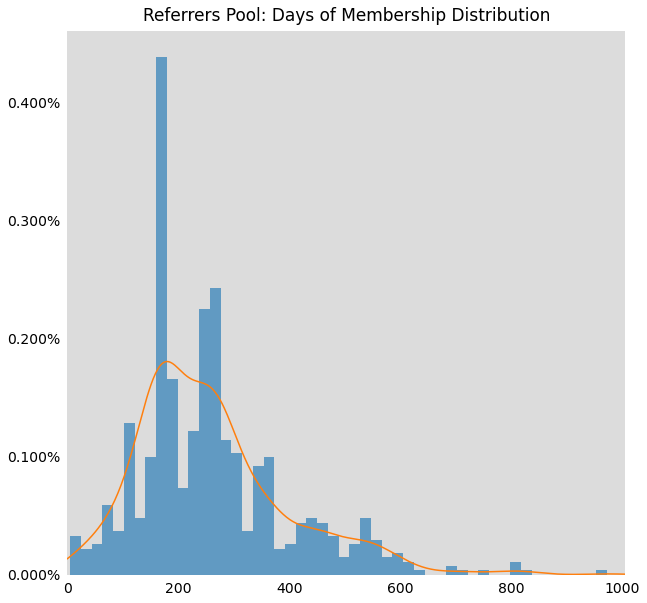

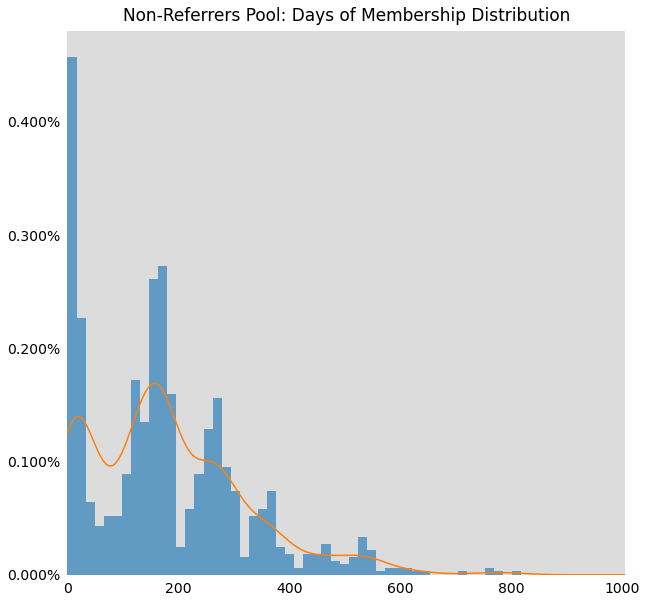

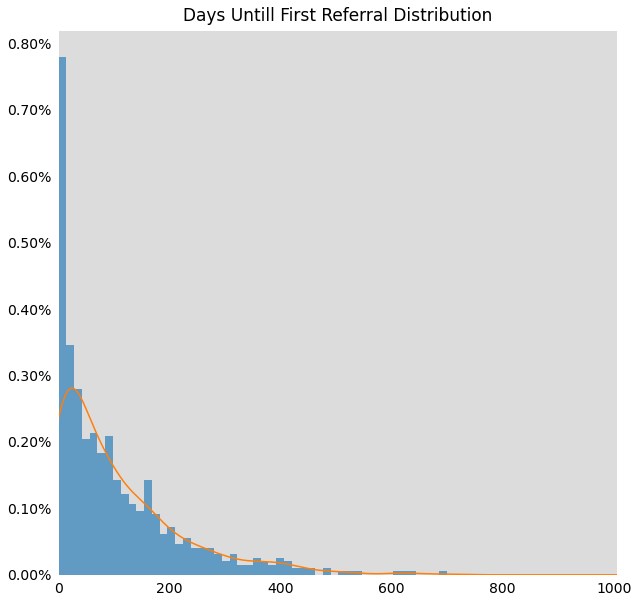

In [7]:
# Define a function plot a histogram
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
    
def plothistogram2(data, title, bins, cumu):
    # Inititalise plot
    fig, ax = plt.subplots(figsize = (10, 10))
    data.plot(kind='hist', density = True, alpha = 0.65, bins=bins, cumulative=cumu)
    data.plot(kind ='kde')
    
    # X axis
    ax.set_xlabel("")
    ax.tick_params(axis='x', labelsize=14)
    x_start, x_end = 0, 1005
    ax.set_xlim(x_start, x_end)

    # Y axis
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylabel("")
    ax.set_yscale(value='linear')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(2))
    

    # Overall
    ax.grid(False)
    ax.set_title(title, size = 17, pad = 10)
    ax.set_facecolor('gainsboro')
    ax.set_frame_on(True)

    # Remove ticks and spines
    ax.tick_params(left = False, bottom = False)
    for ax, spine in ax.spines.items():
        spine.set_visible(False)
    

membership_nonref = Non_referrers['time_with_Bulb']
membership_ref = ref_customer_life_first['time_with_Bulb']
time_to_refer = ref_customer_life_first['time_to_referral']

plothistogram2(membership_ref, 'Referrers Pool: Days of Membership Distribution', 50, False)
plothistogram2(membership_nonref, 'Non-Referrers Pool: Days of Membership Distribution', 50, False)
plothistogram2(time_to_refer, 'Days Untill First Referral Distribution', 50, False)
    


# Modelling

In [8]:
# Create a logistic regression model to determine what influences customers to refer 
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Split out Customer_life data to include only features important for modelling
X = customer_life_first.drop(columns=['First','sign_up_date', 'referral_date', 'No_of_Referrals', 'customer_id', 'sign_up_customer_id', 'referrer', 'time_to_referral'])
# Split out referrer flag as label
y = customer_life_first['referrer']



# Start by splitting data into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)



In [9]:
# Feature Engineering
# Create a onehotencoder object that relables columns after transforming 
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder

#wrapper for one hot encoder to allow labelling of encoded variables 
class OneHotEncoder(SklearnOneHotEncoder):
    def __init__(self, **kwargs):
        super(OneHotEncoder, self).__init__(**kwargs)
        self.fit_flag = False

    def fit(self, X, **kwargs):
        out = super().fit(X)
        self.fit_flag = True
        return out

    def transform(self, X, **kwargs):
        sparse_matrix = super(OneHotEncoder, self).transform(X)
        new_columns = self.get_new_columns(X=X)
        d_out = pd.DataFrame(sparse_matrix.toarray(), columns=new_columns, index=X.index)
        return d_out

    def fit_transform(self, X, **kwargs):
        self.fit(X)
        return self.transform(X)

    def get_new_columns(self, X):
        new_columns = []
        for i, column in enumerate(X.columns):
            j = 0
            while j < len(self.categories_[i]):
                new_columns.append(f'{column}_<{self.categories_[i][j]}>')
                j += 1
        return new_columns
    
    
    
# Define funtion to encode categorrical variables with and rejoin to initial data 
def transform(df):
    cat_columns = df.select_dtypes(include =['object']).columns
    num_columns = df.select_dtypes(include = ['int64']).columns
    ohe = OneHotEncoder( handle_unknown="ignore")
    df_processed = ohe.fit_transform(df[cat_columns])

    #concatinate numeric features from orginal tables with encoded features
    df_processed_full = pd.concat([df_processed,df[num_columns]],axis=1)
    
    return(df_processed_full)



# Transform training data to numeric form
X_train = transform(X_train)
# Transform test data to numeric form
X_test = transform(X_test)


y_train

388     0
1408    1
1125    1
4       0
838     0
       ..
412     0
1153    0
408     0
943     0
1202    0
Name: referrer, Length: 1137, dtype: int32

In [10]:
# Peform chi-square test
from scipy.stats import chi2_contingency, chi2

# Create a contingency table
contigency = pd.crosstab(customer_life.referrer, customer_life.sign_up_channel) 
print(contigency)

# Perform chi-square test of indpendence on the contingency table 
stat, p, dof, expected = chi2_contingency(contigency)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')



sign_up_channel  Bulb Website  Price Comparison Website  Referral
referrer                                                         
0                         195                       599       203
1                         195                       188       449
dof=2
[[212.5915801  428.99890651 355.4095134 ]
 [177.4084199  358.00109349 296.5904866 ]]
probability=0.950, critical=5.991, stat=294.970
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


Mean AUC for 5 Fold Cross Validation: 0.7727714144226998
AUC score on test: 0.7050236819628853
Best estimator Paramters: {'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Logisitc Regression
[[0.7  0.3 ]
 [0.29 0.71]]


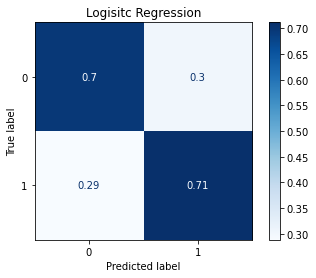

,Weights,Odds Ratio
sign_up_channel_<Bulb Website>,-0.360571,0.697278
sign_up_channel_<Price Comparison Website>,-1.245441,0.287814
sign_up_channel_<Referral>,0.729178,2.073376
time_with_Bulb,0.005631,1.005647


In [11]:
# Train logisit regression model to predict if a customer will referrer a friend

# Model 1: Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score

# Set initial paramters for logistic regression 
# Class weight is set to balanced to account for imbalance in sample
initialparams = {'solver':'liblinear',
                 'class_weight':'balanced',
                 'penalty':'l2',
                 'fit_intercept': True
                }

LogReg = LogisticRegression(**initialparams)

# Use a 10 fold crossvalidation to train model and fit 
params = {}
Tuned_LogReg = GridSearchCV(LogReg, param_grid=params, scoring = 'roc_auc', cv=5)
Tuned_LogReg.fit(X_train,y_train)

# Predict label using model 
Y_pred = Tuned_LogReg.predict(X_test)
# Print model outputs
print('Mean AUC for 5 Fold Cross Validation:', Tuned_LogReg.score(X_train, y_train))
print('AUC score on test:', roc_auc_score(y_true=y_test, y_score=Y_pred))
print('Best estimator Paramters:', Tuned_LogReg.best_estimator_.get_params())



# Plot confusion matrix for logistic regression model on test data
title = 'Logisitc Regression'
np.set_printoptions(precision=2)
disp = plot_confusion_matrix(Tuned_LogReg.best_estimator_, 
                             X_test, 
                             y_test,
                             cmap=plt.cm.Blues,
                             normalize='true')
disp.ax_.set_title(title)
print(title)
print(disp.confusion_matrix)
plt.show()



# Pull features logistic regression model
values = list(Tuned_LogReg.best_estimator_.coef_[0])
keys = list(X_train.columns)
Model_Output = {keys[i]: values[i] for i in range(len(keys))}
Model_Output = pd.DataFrame.from_dict(Model_Output, orient='index')
Model_Output.columns = ['Weights']



# Calculate odds ratio for each feature of logistic regression model
Model_Output['Odds Ratio'] = np.exp(Model_Output.Weights)


Model_Output.head(25)